In [1]:
""" 
O objetivo deste trabalho é analisar padrões históricos e entender 
como as variáveis demográficas e econômicas influenciaram os resultados das eleições de 2016 nos EUA,
A ideia passa por identificar tendências e prever futuras Eleições.

1º dataset apresenta estatísticas demográfica e económica (tamanho 1.4MB )
2º dataset apresenta os dados das eleições de 2016 entre Donald Trump vs Hillary Clinton (tamanho 1.2MB)
 
Por: Marcos Mussungo
"""


import os
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when 


os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Iniciar uma sessão Spark
spark = SparkSession.builder \
    .appName("Eleições 2016 EUA") \
    .getOrCreate()

# Carregar o primeiro dataset
df1 = spark.read.csv("./dados/trump_clinton_polls.csv", header=True, inferSchema=True)

# Carregar o segundo dataset
df2 = spark.read.csv("./dados/county_statistics.csv", header=True, inferSchema=True)

# Mostrar as primeiras linhas dos datasets para verificação
df1.show(5)
df2.show(5)


+----+----------+----------+--------------+--------------------+---------+-----------+----------+--------+------------------+------------------+
| _c0|start_date|  end_date|         state|            pollster|fte_grade|sample_size|population| Clinton|             Trump|          dem_lead|
+----+----------+----------+--------------+--------------------+---------+-----------+----------+--------+------------------+------------------+
|3077|2015-11-07|2015-11-08|South Carolina|Public Policy Pol...|       B+|     1290.0|         v|40.63694|          45.19826|-4.561319999999995|
|6520|2015-11-07|2015-11-08|South Carolina|Public Policy Pol...|       B+|     1290.0|         v| 40.4882|          45.19637|-4.708170000000003|
|9901|2015-11-07|2015-11-08|South Carolina|Public Policy Pol...|       B+|     1290.0|         v|40.69941|          45.18212|-4.482709999999997|
|3206|2015-11-09|2015-11-13|      Virginia|     Roanoke College|       C+|      555.0|        rv|49.81532|           36.2105|13.60

In [2]:
# Selecionar colunas relevantes
df1 = df1.select("start_date", "end_date", "state", "pollster", "fte_grade", "sample_size", "population", "Clinton", "Trump", "dem_lead")

# Remover duplicados e valores nulos
df1 = df1.dropDuplicates().na.drop()
df1.show(5)


+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+
|start_date|  end_date|        state|            pollster|fte_grade|sample_size|population| Clinton|             Trump|          dem_lead|
+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+
|2016-01-04|2016-01-06|New Hampshire|Public Policy Pol...|       B+|     1036.0|         v|47.45498|35.055609999999994|12.399370000000005|
|2016-03-04|2016-03-10|      Florida|      Marist College|        A|     2422.0|        rv|47.09215|          44.50905|2.5830999999999946|
|2016-03-20|2016-03-22|    Wisconsin|     Emerson College|        B|      922.0|        lv|44.41214|36.924659999999996| 7.487480000000005|
|2016-04-10|2016-04-14|         U.S.|               Ipsos|       A-|     1347.0|        lv|44.38128|          35.95729| 8.423989999999996|
|2016-04-23|2016-04-27|    

In [3]:
# Selecionar colunas relevantes
df2 = df2.select("county", "state", "percentage16_Donald_Trump", "percentage16_Hillary_Clinton", "total_votes16", "votes16_Donald_Trump", "votes16_Hillary_Clinton")

# Remover duplicados e valores nulos
df2 = df2.dropDuplicates().na.drop()
df2.show(5)


+----------+-----+-------------------------+----------------------------+-------------+--------------------+-----------------------+
|    county|state|percentage16_Donald_Trump|percentage16_Hillary_Clinton|total_votes16|votes16_Donald_Trump|votes16_Hillary_Clinton|
+----------+-----+-------------------------+----------------------------+-------------+--------------------+-----------------------+
|    Butler|   AL|                    0.563|                       0.428|       8685.0|              4891.0|                 3716.0|
|   Cascade|   MT|                     0.57|                       0.355|      33923.0|             19343.0|                12053.0|
|Cumberland|   PA|                    0.571|                       0.385|     115068.0|             65649.0|                44282.0|
| Dougherty|   GA|                    0.301|                       0.685|      33925.0|             10227.0|                23224.0|
| Fairfield|   SC|                    0.358|                       0.

In [4]:
df1.select("population").distinct().show()

+----------+
|population|
+----------+
|        lv|
|         v|
|         a|
|        rv|
+----------+



In [5]:
df1 = df1.withColumn("population_numeric", 
                      when(col("population") == "v", 1)
                     .when(col("population") == "rv", 2)
                     .when(col("population") == "lv", 3)
                     .when(col("population") == "a", 4)
                     .otherwise(None))

In [6]:
df1.select("population", "population_numeric").distinct().show()

+----------+------------------+
|population|population_numeric|
+----------+------------------+
|        rv|                 2|
|         a|                 4|
|        lv|                 3|
|         v|                 1|
+----------+------------------+



In [7]:
df1.select("state").distinct().show(4, truncate=False)
df2.select("state").distinct().show(4, truncate=False)

+---------+
|state    |
+---------+
|Utah     |
|Hawaii   |
|Minnesota|
|Ohio     |
+---------+
only showing top 4 rows

+-----+
|state|
+-----+
|SC   |
|AZ   |
|LA   |
|MN   |
+-----+
only showing top 4 rows



In [8]:
from pyspark.sql.functions import col, trim, create_map, lit, lower
from pyspark.sql.types import StringType
from itertools import chain

# Dicionário de mapeamento de nomes completos para abreviações
state_abbreviation = {
    "alabama": "AL", "alaska": "AK", "arizona": "AZ", "arkansas": "AR", "california": "CA", 
    "colorado": "CO", "connecticut": "CT", "delaware": "DE", "florida": "FL", "georgia": "GA", 
    "hawaii": "HI", "idaho": "ID", "illinois": "IL", "indiana": "IN", "iowa": "IA", "kansas": "KS", 
    "kentucky": "KY", "louisiana": "LA", "maine": "ME", "maryland": "MD", "massachusetts": "MA", 
    "michigan": "MI", "minnesota": "MN", "mississippi": "MS", "missouri": "MO", "montana": "MT", 
    "nebraska": "NE", "nevada": "NV", "new hampshire": "NH", "new jersey": "NJ", "new mexico": "NM", 
    "new york": "NY", "north carolina": "NC", "north dakota": "ND", "ohio": "OH", "oklahoma": "OK", 
    "oregon": "OR", "pennsylvania": "PA", "rhode island": "RI", "south carolina": "SC", 
    "south dakota": "SD", "tennessee": "TN", "texas": "TX", "utah": "UT", "vermont": "VT", 
    "virginia": "VA", "washington": "WA", "west virginia": "WV", "wisconsin": "WI", "wyoming": "WY",
    "district of columbia": "DC"
}



# Criar uma coluna de mapeamento no dataframe
mapping_expr = create_map([lit(x) for x in chain(*state_abbreviation.items())])

# Aplicar o mapeamento no dataframe df1 (assumindo que df1 tem os nomes completos dos estados)
df1 = df1.withColumn("state", trim(lower(col("state"))))
df1 = df1.withColumn("state_abbreviation", mapping_expr[trim(col("state"))])

# Garantir consistência nos nomes dos estados no dataframe df2 (assumindo que df2 já tem as abreviações)
df2 = df2.withColumn("state", trim(col("state")))
df1.show(5)


+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+------------------+------------------+
|start_date|  end_date|        state|            pollster|fte_grade|sample_size|population| Clinton|             Trump|          dem_lead|population_numeric|state_abbreviation|
+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+------------------+------------------+
|2016-01-04|2016-01-06|new hampshire|Public Policy Pol...|       B+|     1036.0|         v|47.45498|35.055609999999994|12.399370000000005|                 1|                NH|
|2016-03-04|2016-03-10|      florida|      Marist College|        A|     2422.0|        rv|47.09215|          44.50905|2.5830999999999946|                 2|                FL|
|2016-03-20|2016-03-22|    wisconsin|     Emerson College|        B|      922.0|        lv|44.41214|36.924659999999

In [9]:
# Listar os estados que não foram mapeados
df1.filter(col("state_abbreviation").isNull()).select("state").distinct().show()


+-------------+
|        state|
+-------------+
|nebraska cd-2|
|   maine cd-1|
|         u.s.|
|   maine cd-2|
|nebraska cd-3|
|nebraska cd-1|
+-------------+



In [10]:
from pyspark.sql.functions import trim, lower, col
# Normalizar os nomes dos estados no dataframe df1
df1 = df1.withColumn("state", trim(lower(col("state"))))

# Reaplicar o mapeamento após normalização
df1 = df1.withColumn("state_abbreviation", mapping_expr[col("state")])
df1.show(5)

+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+------------------+------------------+
|start_date|  end_date|        state|            pollster|fte_grade|sample_size|population| Clinton|             Trump|          dem_lead|population_numeric|state_abbreviation|
+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+------------------+------------------+
|2016-01-04|2016-01-06|new hampshire|Public Policy Pol...|       B+|     1036.0|         v|47.45498|35.055609999999994|12.399370000000005|                 1|                NH|
|2016-03-04|2016-03-10|      florida|      Marist College|        A|     2422.0|        rv|47.09215|          44.50905|2.5830999999999946|                 2|                FL|
|2016-03-20|2016-03-22|    wisconsin|     Emerson College|        B|      922.0|        lv|44.41214|36.924659999999

In [11]:
# Tratamento de valores especiais
df1 = df1.withColumn(
    "state_abbreviation",
    when(col("state") == "u.s.", None).
    when(col("state").like("%cd-%"), None). # Ignorar distritos eleitorais
    otherwise(col("state_abbreviation"))
)
df1.show(5)

+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+------------------+------------------+
|start_date|  end_date|        state|            pollster|fte_grade|sample_size|population| Clinton|             Trump|          dem_lead|population_numeric|state_abbreviation|
+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+------------------+------------------+
|2016-01-04|2016-01-06|new hampshire|Public Policy Pol...|       B+|     1036.0|         v|47.45498|35.055609999999994|12.399370000000005|                 1|                NH|
|2016-03-04|2016-03-10|      florida|      Marist College|        A|     2422.0|        rv|47.09215|          44.50905|2.5830999999999946|                 2|                FL|
|2016-03-20|2016-03-22|    wisconsin|     Emerson College|        B|      922.0|        lv|44.41214|36.924659999999

In [12]:
df1_cleaned = df1.filter(col("state_abbreviation").isNotNull())

In [13]:
# Verificar se há valores nulos na coluna state_abbreviation após o tratamento
df1_cleaned.filter(col("state_abbreviation").isNull()).select("state").distinct().show()

+-----+
|state|
+-----+
+-----+



In [14]:
from pyspark.sql.functions import trim, lower

df1_cleaned = df1_cleaned.withColumn("state_abbreviation", trim(lower(col("state_abbreviation"))))
df2 = df2.withColumn("state", trim(lower(col("state"))))
df1_cleaned.show(5)
df2.show(5)

+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+------------------+------------------+
|start_date|  end_date|        state|            pollster|fte_grade|sample_size|population| Clinton|             Trump|          dem_lead|population_numeric|state_abbreviation|
+----------+----------+-------------+--------------------+---------+-----------+----------+--------+------------------+------------------+------------------+------------------+
|2016-01-04|2016-01-06|new hampshire|Public Policy Pol...|       B+|     1036.0|         v|47.45498|35.055609999999994|12.399370000000005|                 1|                nh|
|2016-03-04|2016-03-10|      florida|      Marist College|        A|     2422.0|        rv|47.09215|          44.50905|2.5830999999999946|                 2|                fl|
|2016-03-20|2016-03-22|    wisconsin|     Emerson College|        B|      922.0|        lv|44.41214|36.924659999999

In [15]:
df1_cleaned.filter(col("state_abbreviation").isNull()).show()
df2.filter(col("state").isNull()).show()


+----------+--------+-----+--------+---------+-----------+----------+-------+-----+--------+------------------+------------------+
|start_date|end_date|state|pollster|fte_grade|sample_size|population|Clinton|Trump|dem_lead|population_numeric|state_abbreviation|
+----------+--------+-----+--------+---------+-----------+----------+-------+-----+--------+------------------+------------------+
+----------+--------+-----+--------+---------+-----------+----------+-------+-----+--------+------------------+------------------+

+------+-----+-------------------------+----------------------------+-------------+--------------------+-----------------------+
|county|state|percentage16_Donald_Trump|percentage16_Hillary_Clinton|total_votes16|votes16_Donald_Trump|votes16_Hillary_Clinton|
+------+-----+-------------------------+----------------------------+-------------+--------------------+-----------------------+
+------+-----+-------------------------+----------------------------+-------------+-----

In [16]:
# Eliminar as colunas 'state' e 'population' do DataFrame df1_cleaned
df1_cleaned = df1_cleaned.drop("state").drop("population")

# Verificar os primeiros registros para confirmar a remoção das colunas
df1_cleaned.show(7)

+----------+----------+--------------------+---------+-----------+--------+------------------+------------------+------------------+------------------+
|start_date|  end_date|            pollster|fte_grade|sample_size| Clinton|             Trump|          dem_lead|population_numeric|state_abbreviation|
+----------+----------+--------------------+---------+-----------+--------+------------------+------------------+------------------+------------------+
|2016-01-04|2016-01-06|Public Policy Pol...|       B+|     1036.0|47.45498|35.055609999999994|12.399370000000005|                 1|                nh|
|2016-03-04|2016-03-10|      Marist College|        A|     2422.0|47.09215|          44.50905|2.5830999999999946|                 2|                fl|
|2016-03-20|2016-03-22|     Emerson College|        B|      922.0|44.41214|36.924659999999996| 7.487480000000005|                 3|                wi|
|2016-05-22|2016-05-26|       Siena College|        A|      825.0|53.77025|36.0220099999

In [17]:
# Realizar o join usando 'state_abbreviation' de df1 e 'state' de df2
merged_df = df1_cleaned.join(df2, df1_cleaned.state_abbreviation == df2.state, how='inner')

# Mostrar os primeiros registros do DataFrame resultante
merged_df.show(10)

+----------+----------+--------------------+---------+-----------+--------+------------------+------------------+------------------+------------------+------------+-----+-------------------------+----------------------------+-------------+--------------------+-----------------------+
|start_date|  end_date|            pollster|fte_grade|sample_size| Clinton|             Trump|          dem_lead|population_numeric|state_abbreviation|      county|state|percentage16_Donald_Trump|percentage16_Hillary_Clinton|total_votes16|votes16_Donald_Trump|votes16_Hillary_Clinton|
+----------+----------+--------------------+---------+-----------+--------+------------------+------------------+------------------+------------------+------------+-----+-------------------------+----------------------------+-------------+--------------------+-----------------------+
|2016-01-04|2016-01-06|Public Policy Pol...|       B+|     1036.0|47.45498|35.055609999999994|12.399370000000005|                 1|             

In [18]:
"""    
Definir o Alvo do Modelo: 
A coluna Clinton_to_Trump_Ratio é criada para servir como o nosso  alvo
Esta variável representa a razão entre o percentual de votos de Hillary Clinton e o percentual de votos de Donald Trump.

Uma razão maior que 1 indica que Clinton recebeu mais votos que Trump, enquanto uma razão menor que 1 indica o oposto.

"""

# Criar a coluna target
merged_df = merged_df.withColumn("Clinton_to_Trump_Ratio", col("percentage16_Hillary_Clinton") / col("percentage16_Donald_Trump"))
merged_df.show(5)

+----------+----------+--------------------+---------+-----------+--------+------------------+------------------+------------------+------------------+----------+-----+-------------------------+----------------------------+-------------+--------------------+-----------------------+----------------------+
|start_date|  end_date|            pollster|fte_grade|sample_size| Clinton|             Trump|          dem_lead|population_numeric|state_abbreviation|    county|state|percentage16_Donald_Trump|percentage16_Hillary_Clinton|total_votes16|votes16_Donald_Trump|votes16_Hillary_Clinton|Clinton_to_Trump_Ratio|
+----------+----------+--------------------+---------+-----------+--------+------------------+------------------+------------------+------------------+----------+-----+-------------------------+----------------------------+-------------+--------------------+-----------------------+----------------------+
|2016-01-04|2016-01-06|Public Policy Pol...|       B+|     1036.0|47.45498|35.0556

In [36]:
# Eliminar as colunas 'state'  do DataFrame merged_df
merged_df = merged_df.drop("state")

# Verificar os primeiros registros para confirmar a remoção da coluna
merged_df.show(7)

+----------+----------+--------------------+---------+-----------+--------+------------------+------------------+------------------+------------------+----------+-------------------------+----------------------------+-------------+--------------------+-----------------------+----------------------+
|start_date|  end_date|            pollster|fte_grade|sample_size| Clinton|             Trump|          dem_lead|population_numeric|state_abbreviation|    county|percentage16_Donald_Trump|percentage16_Hillary_Clinton|total_votes16|votes16_Donald_Trump|votes16_Hillary_Clinton|Clinton_to_Trump_Ratio|
+----------+----------+--------------------+---------+-----------+--------+------------------+------------------+------------------+------------------+----------+-------------------------+----------------------------+-------------+--------------------+-----------------------+----------------------+
|2016-01-04|2016-01-06|Public Policy Pol...|       B+|     1036.0|47.45498|35.055609999999994|12.399

In [19]:
selected_columns = [
    "sample_size", "Clinton", "Trump", "dem_lead", 
    "population_numeric", "percentage16_Donald_Trump", 
    "percentage16_Hillary_Clinton", "total_votes16", 
    "votes16_Donald_Trump", "votes16_Hillary_Clinton"
]

# Selecionar colunas para modelagem
data = merged_df.select(*selected_columns, "Clinton_to_Trump_Ratio")
data.show(5)


+-----------+--------+------------------+------------------+------------------+-------------------------+----------------------------+-------------+--------------------+-----------------------+----------------------+
|sample_size| Clinton|             Trump|          dem_lead|population_numeric|percentage16_Donald_Trump|percentage16_Hillary_Clinton|total_votes16|votes16_Donald_Trump|votes16_Hillary_Clinton|Clinton_to_Trump_Ratio|
+-----------+--------+------------------+------------------+------------------+-------------------------+----------------------------+-------------+--------------------+-----------------------+----------------------+
|     1036.0|47.45498|35.055609999999994|12.399370000000005|                 1|                    0.505|                       0.447|     178964.0|             90447.0|                79994.0|    0.8851485148514852|
|     1036.0|47.45498|35.055609999999994|12.399370000000005|                 1|                    0.488|                       0.46

In [20]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Dividir os dados em treinamento e teste
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# VectorAssembler para transformar colunas de entrada em um vetor de características
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")

# Configurar o modelo Random Forest
rf = RandomForestRegressor(labelCol="Clinton_to_Trump_Ratio", featuresCol="features", numTrees=100)

# Criar um pipeline que inclui a transformação dos dados e o modelo
pipeline = Pipeline(stages=[assembler, rf])



# Configurar a validação cruzada
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [50, 100]).addGrid(rf.maxDepth, [5, 10]).build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="Clinton_to_Trump_Ratio", predictionCol="prediction"),
                          numFolds=5)

# Treinar o modelo
model = crossval.fit(train_data)



In [21]:

# Fazer previsões nos dados de teste
predictions = model.transform(test_data)

# Avaliar o modelo
evaluator = RegressionEvaluator(labelCol="Clinton_to_Trump_Ratio", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Erro Médio de Raiz Quadrada (RMSE) nos dados de teste = {rmse}")


Erro Médio de Raiz Quadrada (RMSE) nos dados de teste = 0.08157020748515383


In [22]:
from pyspark.ml.evaluation import RegressionEvaluator

# Avaliar o modelo com MAE
evaluator_mae = RegressionEvaluator(labelCol="Clinton_to_Trump_Ratio", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"Erro Médio Absoluto (MAE) nos dados de teste = {mae}")

# Avaliar o modelo com R²
evaluator_r2 = RegressionEvaluator(labelCol="Clinton_to_Trump_Ratio", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-quadrado (R²) nos dados de teste = {r2}")


Erro Médio Absoluto (MAE) nos dados de teste = 0.016950479038442212
R-quadrado (R²) nos dados de teste = 0.989297464069435


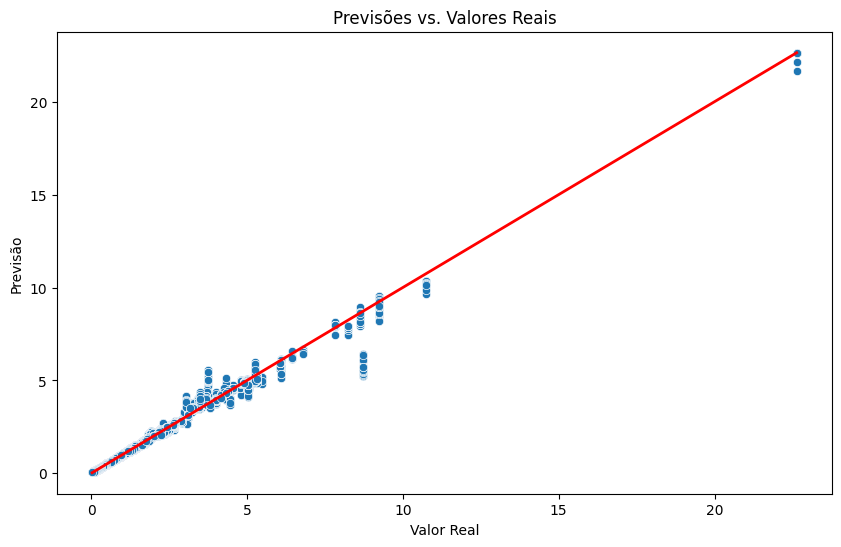

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converter o DataFrame do Spark para um DataFrame do Pandas
predictions_pd = predictions.select("prediction", "Clinton_to_Trump_Ratio").toPandas()

# Plotar as previsões vs. valores reais
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Clinton_to_Trump_Ratio", y="prediction", data=predictions_pd)
plt.plot([predictions_pd["Clinton_to_Trump_Ratio"].min(), predictions_pd["Clinton_to_Trump_Ratio"].max()],
         [predictions_pd["Clinton_to_Trump_Ratio"].min(), predictions_pd["Clinton_to_Trump_Ratio"].max()],
         color='red', linewidth=2)
plt.xlabel("Valor Real")
plt.ylabel("Previsão")
plt.title("Previsões vs. Valores Reais")
plt.show()


In [24]:
predictions_pd = predictions.select("Clinton_to_Trump_Ratio", "prediction").toPandas()

# Plotar Importância das Características
def plot_feature_importances(importances, features):
    feature_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances)
    plt.title('Importância das Características')
    plt.show()

In [25]:
# Plotar Previsões vs Valores Reais
def plot_predictions_vs_actuals(predictions_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Clinton_to_Trump_Ratio', y='prediction', data=predictions_df)
    plt.plot([0, 1], [0, 1], '--', color='red')  # Linha de referência
    plt.title('Previsões vs Valores Reais')
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.show()

In [26]:
# Plotar Distribuição dos Erros
def plot_error_distribution(predictions_df):
    predictions_df['error'] = predictions_df['Clinton_to_Trump_Ratio'] - predictions_df['prediction']
    plt.figure(figsize=(10, 6))
    sns.histplot(predictions_df['error'], bins=20, kde=True)
    plt.title('Distribuição dos Erros')
    plt.xlabel('Erro')
    plt.ylabel('Frequência')
    plt.show()

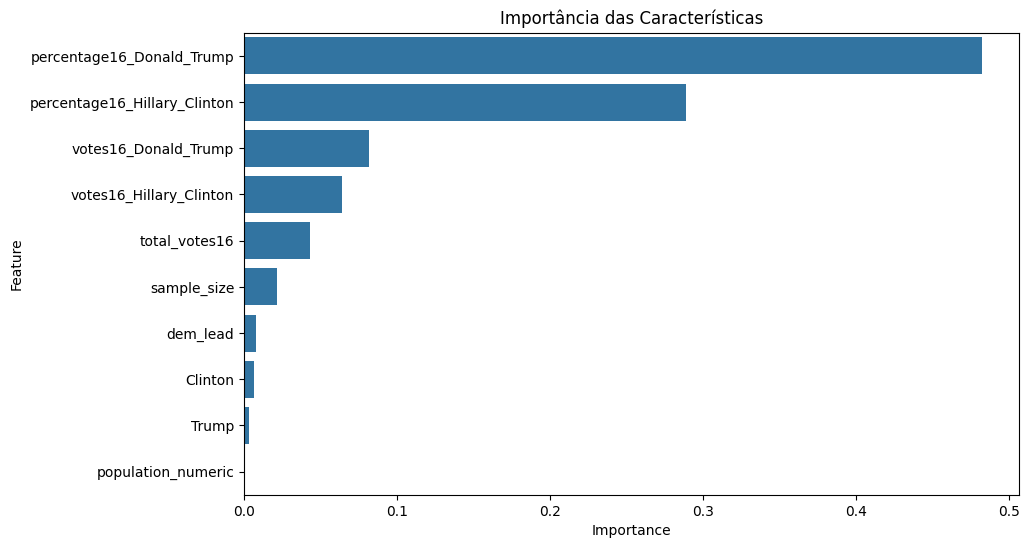

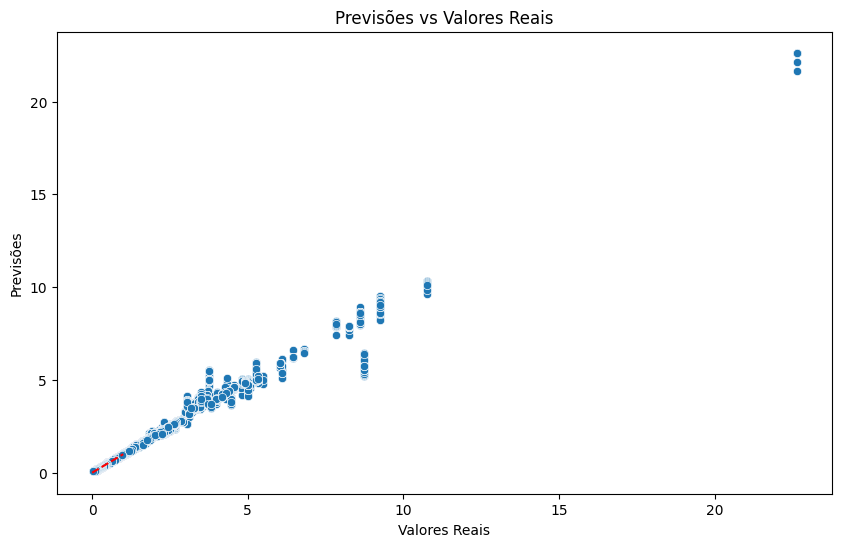

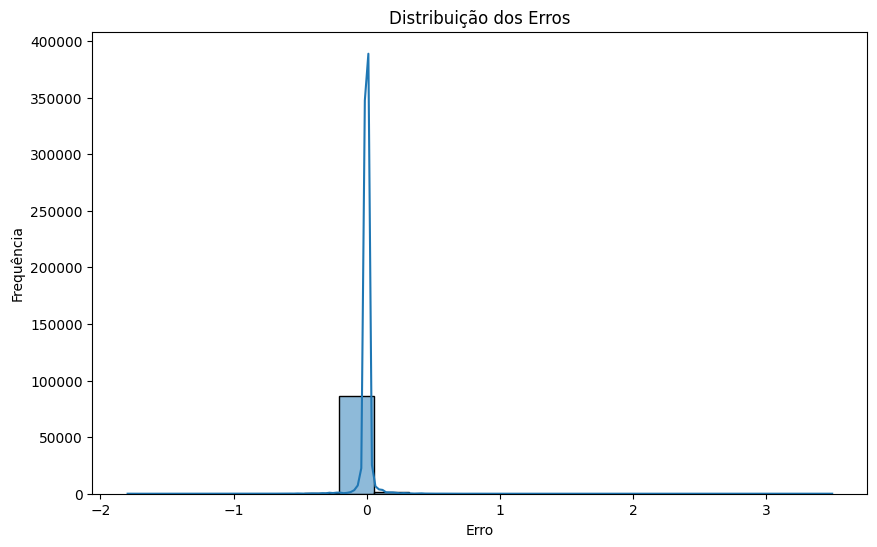

In [35]:
# Calcular importâncias das características
rf_model = model.bestModel.stages[-1]
importances = rf_model.featureImportances.toArray()

# Plotar análises gráficas
plot_feature_importances(importances, selected_columns)
plot_predictions_vs_actuals(predictions_pd)
plot_error_distribution(predictions_pd)

In [ ]:
# Salvar o modelo
model_path = "Random_Forest_Modelo"
model.bestModel.write().overwrite().save(model_path)
print(f"Modelo salvo com Sucesso em: {model_path}")